In [ ]:
from TradingBot.utils.tradebot import MACD
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from TradingBot.utils.tradebot import *
#import backtrader as bt
import warnings
warnings.filterwarnings("ignore")

In [14]:
def get_data(tiker='^IXIC', start="2022-05-05", end="2022-05-06", which='Close', interval='1m'):
    '''
    # Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # see https://github.com/ranaroussi/yfinance/blob/9eef951acc70121e65825ad25e7afd2edd4c3e4b/yfinance/multi.py
    '''
    def reformulate_date(df):
        df.columns = df.columns.map(''.join)
        df = df.rename_axis('Date').reset_index()
        return df
    data = yf.download(tickers = tiker, start=start, end=end, interval = interval, progress=False)
    data['pct_change'] = data[which].pct_change()
    data['log_ret'] = np.log(data[which]) - np.log(data[which].shift(1))
    data = reformulate_date(data)
    #print("most recent date is ", data.iloc[-1, 0])
    return data

In [15]:
def create_trade_sig(prices, emas, macds, sigs):
    '''
    len(prices) = len(emas) = ... = len(long)
    '''
    long = []
    short = []
    empty = []
    for i, (price, ema, macd, sig) in enumerate(zip(prices, emas, macds, sigs)):
        if price > ema: # long-term = long            
            if macd > sig:
                long.append(1)
                short.append(0)
                empty.append(0)               
            else:
                long.append(0)
                short.append(0)
                empty.append(1)
        else:
            if macd < sig:
                long.append(0)
                short.append(1)
                empty.append(0)               
            else:
                long.append(0)
                short.append(0)
                empty.append(1)
    
    for long_, short_, empty_ in zip(long, short, empty):
        assert ((long_ + short_ + empty_) == 1)
    
    #return long, short, empty
    return long[:-1], short[:-1], empty[:-1] # last signal is useless
    
def plot_(price, emas, sigs, macds, focal_row_nums):
    df = pd.DataFrame({'sig':sigs, 'macd':macds})

    # ------------
    focal_row_nums=[]
    figure_size = (10, 5)
    fig, ax = plt.subplots(figsize=figure_size)
    
    ax.plot(price, label="Price")
    ax.plot(emas, label='ema')
    
    if len(focal_row_nums) != 0:
        for focal_row_num in focal_row_nums:
            ax.vlines(ymin=np.min(price), ymax=np.max(price), x=focal_row_num, color='r', linestyle='-.')

    ax.plot()
    ax.legend()

    # ------------
    df.plot(figsize=figure_size)                 

def strategy_macd(macd_short=12, macd_long=26, sig_sf=9, ema_sf=200, short_ticker='SQQQ', long_ticker='TQQQ', signal_ticker='^IXIC', data_freq='1d', start='2022-01-01', end='2022-06-01', which='Close', if_plot=False, focal_row_nums=[]):
    # ----
    nasdaq = get_data(tiker=signal_ticker, start=start, end=end, which=which, interval = data_freq)
    tqqq = get_data(tiker=long_ticker, start=start, end=end, which=which, interval = data_freq)
    sqqq =  get_data(tiker=short_ticker, start=start, end=end, which=which, interval = data_freq)
    assert nasdaq.shape[0] == tqqq.shape[0] == tqqq.shape[0]
    
    # ---- compute macd
    prices = nasdaq[which].values
    _, _, macds, sigs, _ = MACD(CLOSE=prices,SHORT=macd_short, LONG=macd_long, M=sig_sf)
    emas = EMA(prices, ema_sf)
    
    # ---- plot if 
    if if_plot:
        plot_(prices, emas, sigs, macds, focal_row_nums)
    
    # ---- sig
    long_sig, short_sig, empty_sig = create_trade_sig(prices=prices, emas=emas, macds=macds, sigs=sigs)

    # return 
    log_return_long = np.array(tqqq['log_ret'].values[1:]).dot(np.array(long_sig))
    log_return_short = np.array(sqqq['log_ret'].values[1:]).dot(np.array(short_sig))
    
    return_total = np.exp(log_return_long + log_return_short)
    return return_total,  np.exp(log_return_long), np.exp(log_return_short), prices
    
    

total return in testing period: 1.42
long ret 1.20 short ret 1.19


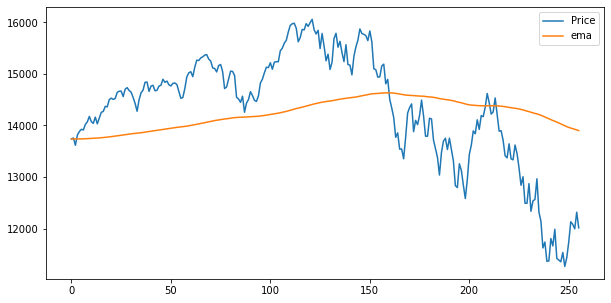

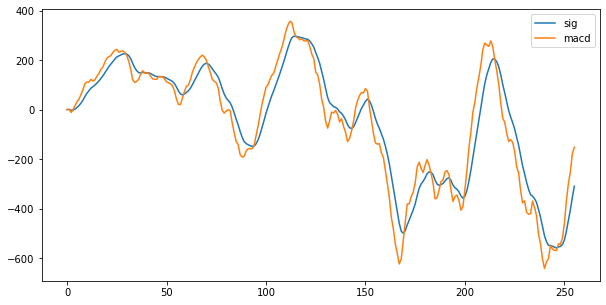

In [25]:
# 1d
short = 'SQQQ'
long = 'TQQQ'
end_date = '2022-06-05'
ret, ret_l, ret_s, pric = strategy_macd(macd_short=10, macd_long=26, sig_sf=8, ema_sf=300, short_ticker=short, long_ticker=long, signal_ticker='^IXIC', data_freq='1d', start='2021-06-01', end=end_date, which='Close', if_plot=True)

print("total return in testing period: {:.2f}".format(ret))
print("long ret {:.2f}".format(round(ret_l, 2)), "short ret {:.2f}".format(round(ret_s,2)))

total return in testing period: 1.50
long ret 1.00 short ret 1.50


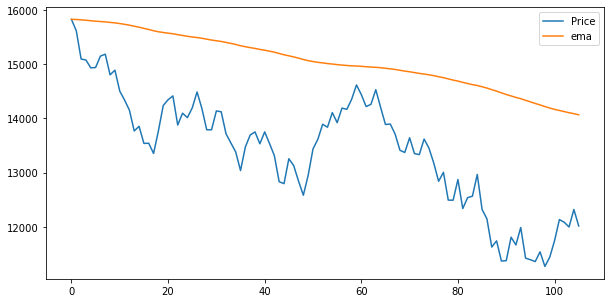

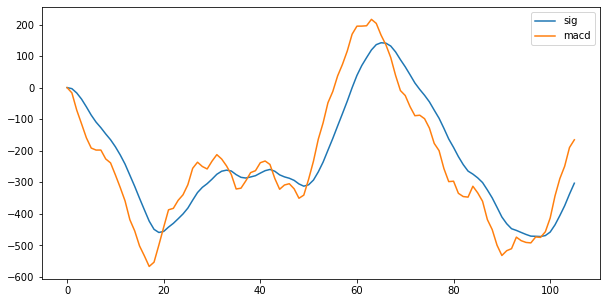

In [26]:
# 1d
start_date = '2022-01-01'
end_date = '2022-06-05'
freq = '1d'
ret, ret_l, ret_s, pric = strategy_macd(macd_short=12, macd_long=26, sig_sf=9, ema_sf=200, short_ticker='SQQQ', long_ticker='TQQQ', signal_ticker='^IXIC', data_freq=freq, start=start_date, end=end_date, which='Close', if_plot=True)

print("total return in testing period: {:.2f}".format(ret))
print("long ret {:.2f}".format(round(ret_l, 2)), "short ret {:.2f}".format(round(ret_s,2)))

In [18]:
# 1h

def rolling_month(freq='1h'):
    
    short = 'SQQQ'
    long = 'TQQQ'

    starts = [4, 5]
    ends = [ele+1 for ele in starts]


    for sta,end in zip(starts, ends):   

        start_date = f'2022-0{sta}-05'
        end_date = f'2022-0{end}-02'
        ret, ret_l, ret_s, pric = strategy_macd(macd_short=8, macd_long=22, sig_sf=9, ema_sf=200, short_ticker=short, long_ticker=long, signal_ticker='^IXIC', data_freq=freq, start=start_date, end=end_date, which='Close', if_plot=False)
        print("total_ret:", ret, ret_l, ret_s)


total return in testing period: 1.62
long ret 0.97 short ret 1.67


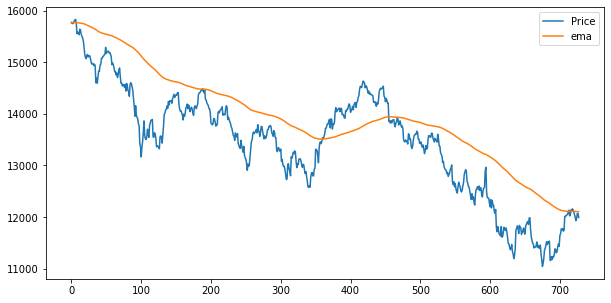

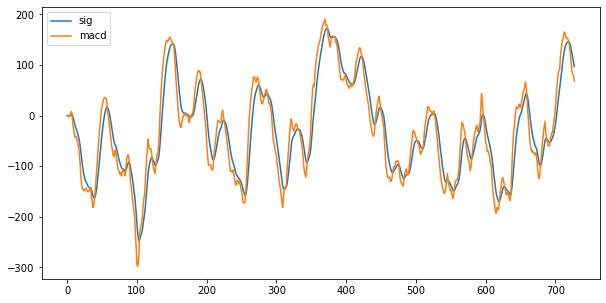

In [19]:
# 1h
short = 'SQQQ'
long = 'TQQQ'

start_date = '2022-01-01'
end_date = '2022-06-02'
freq = '1h'
ret, ret_l, ret_s, pric = strategy_macd(macd_short=12, macd_long=24, sig_sf=9, ema_sf=200, short_ticker=short, long_ticker=long, signal_ticker='^IXIC', data_freq=freq, start=start_date, end=end_date, which='Close', if_plot=True)

print("total return in testing period: {:.2f}".format(ret))
print("long ret {:.2f}".format(round(ret_l, 2)), "short ret {:.2f}".format(round(ret_s,2)))

total return in testing period: 1.74
long ret 0.96 short ret 1.82


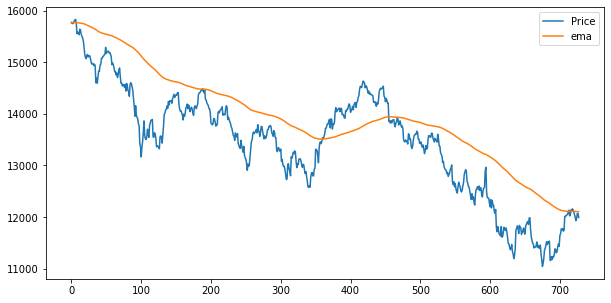

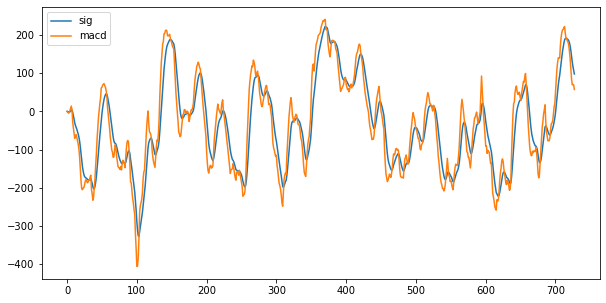

In [20]:
# 1h
short = 'SQQQ'
long = 'TQQQ'
start_date = '2022-01-01'
end_date = '2022-06-02'
freq = '1h'
ret, ret_l, ret_s, pric = strategy_macd(macd_short=8, macd_long=22, sig_sf=9, ema_sf=200, short_ticker=short, long_ticker=long, signal_ticker='^IXIC', data_freq=freq, start=start_date, end=end_date, which='Close', if_plot=True)

print("total return in testing period: {:.2f}".format(ret))
print("long ret {:.2f}".format(round(ret_l, 2)), "short ret {:.2f}".format(round(ret_s,2)))


1 Failed download:
- ^IXIC: 15m data not available for startTime=1649131200 and endTime=1654228800. The requested range must be within the last 60 days.

1 Failed download:
- TQQQ: 15m data not available for startTime=1649131200 and endTime=1654228800. The requested range must be within the last 60 days.

1 Failed download:
- SQQQ: 15m data not available for startTime=1649131200 and endTime=1654228800. The requested range must be within the last 60 days.
total return in testing period: 1.00
long ret 1.00 short ret 1.00


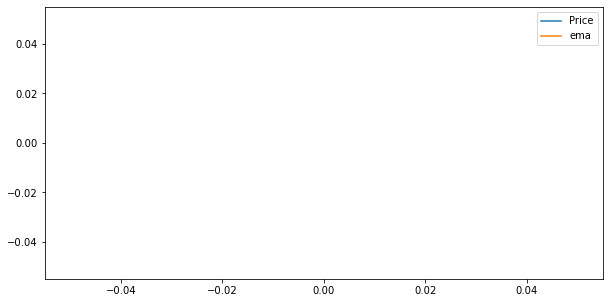

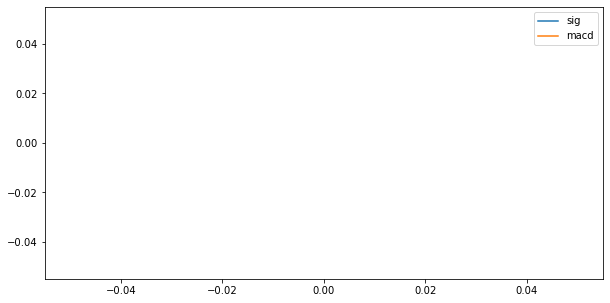

In [21]:
# 30m
start_date = '2022-04-05'
end_date = '2022-06-03'
freq = '30m'
ret, ret_l, ret_s, pric = strategy_macd(macd_short=12, macd_long=26, sig_sf=9, ema_sf=300, short_ticker='SQQQ', long_ticker='TQQQ', signal_ticker='^IXIC', data_freq=freq, start=start_date, end=end_date, which='Close', if_plot=True)

print("total return in testing period: {:.2f}".format(ret))
print("long ret {:.2f}".format(round(ret_l, 2)), "short ret {:.2f}".format(round(ret_s,2)))

In [22]:
rolling_month(freq='15m')


1 Failed download:
- ^IXIC: 15m data not available for startTime=1649131200 and endTime=1651464000. The requested range must be within the last 60 days.

1 Failed download:
- TQQQ: 15m data not available for startTime=1649131200 and endTime=1651464000. The requested range must be within the last 60 days.

1 Failed download:
- SQQQ: 15m data not available for startTime=1649131200 and endTime=1651464000. The requested range must be within the last 60 days.
total_ret: 1.0 1.0 1.0
total_ret: 1.098535420052052 0.9325671839143039 1.177969200504271



1 Failed download:
- ^IXIC: 15m data not available for startTime=1649131200 and endTime=1654228800. The requested range must be within the last 60 days.

1 Failed download:
- TQQQ: 15m data not available for startTime=1649131200 and endTime=1654228800. The requested range must be within the last 60 days.

1 Failed download:
- SQQQ: 15m data not available for startTime=1649131200 and endTime=1654228800. The requested range must be within the last 60 days.
total return in testing period: 1.00
long ret 1.00 short ret 1.00


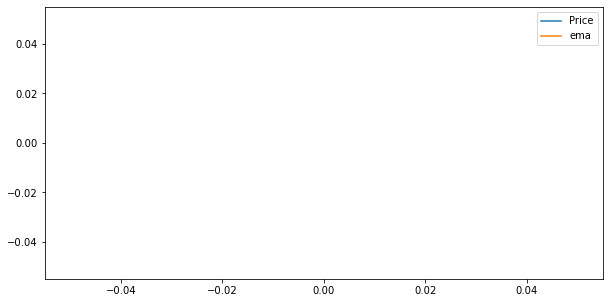

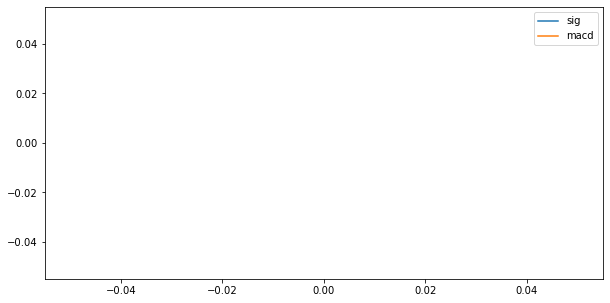

In [23]:
# 15m
start_date = '2022-04-05'
end_date = '2022-06-03'
freq = '15m'
ret, ret_l, ret_s, pric = strategy_macd(macd_short=12, macd_long=26, sig_sf=9, ema_sf=300, short_ticker='SQQQ', long_ticker='TQQQ', signal_ticker='^IXIC', data_freq=freq, start=start_date, end=end_date, which='Close', if_plot=True)

print("total return in testing period: {:.2f}".format(ret))
print("long ret {:.2f}".format(round(ret_l, 2)), "short ret {:.2f}".format(round(ret_s,2)))

In [24]:
# # 5m
# start_date = '2022-05-05'
# end_date = '2022-06-03'
# freq = '5m'
# ret, ret_l, ret_s, pric = strategy_macd(macd_short=8, macd_long=20, sig_sf=6, ema_sf=500, short_ticker='SQQQ', long_ticker='TQQQ', signal_ticker='^IXIC', data_freq=freq, start=start_date, end=end_date, which='Close', if_plot=True)

# print("total return in testing period: {:.2f}".format(ret))
# print("long ret {:.2f}".format(round(ret_l, 2)), "short ret {:.2f}".format(round(ret_s,2)))